In [ ]:
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import truncnorm
from matplotlib import cm
import scipy.io

class WanPDESolver(nn.Module):

    def __init__(self, dim, N_dm, N_bd, file_path, beta_int, beta_intw, beta_bd,
                 v_step, v_rate, u_step, u_rate, u_layer=6, u_neuron=40,
                 iteration=20001, device='cuda'):
        super(WanPDESolver, self).__init__()

        self.device = device
        self.low, self.up = -1.0, 1.0
        self.dim = dim
        self.mesh_size = 50
        self.dm_size = N_dm
        self.bd_size = N_bd
        self.iteration = iteration
        self.dir = file_path
        self.beta_int = beta_int
        self.beta_intw = beta_intw
        self.beta_bd = beta_bd


        self.v_layer = 6
        self.v_h_size = 40
        self.v_step = v_step
        self.v_rate = v_rate

        self.u_layer = u_layer
        self.u_h_size = u_neuron
        self.u_step = u_step
        self.u_rate = u_rate


        self.net_u = NetU(dim, 1, u_layer, u_neuron).to(device)
        self.net_v = NetV(dim, 1, self.v_layer, self.v_h_size).to(device)


        self.optimizer_u = torch.optim.Adam(self.net_u.parameters(), lr=u_rate)
        self.optimizer_v = torch.optim.Adagrad(self.net_v.parameters(), lr=v_rate)

    def sample_train(self, dm_size, bd_size, dim):
        low, up = self.low, self.up

        x_dm = np.random.uniform(low, up, [dm_size, dim])

        x_sin = np.sin(np.pi*x_dm/2)
        f_dm = (np.pi**2/4.0)*np.sum(x_sin, axis=1)
        f_dm = np.reshape(f_dm, [-1,1])

        x_bd_list = []
        for i in range(dim):
            x_bound = np.random.uniform(low, up, [bd_size, dim])
            x_bound[:,i] = up
            x_bd_list.append(x_bound)
            x_bound = np.random.uniform(low, up, [bd_size, dim])
            x_bound[:,i] = low
            x_bd_list.append(x_bound)
        x_bd = np.concatenate(x_bd_list, axis=0)

        x_sin = np.sin(np.pi*x_bd/2)
        u_bd = np.sum(x_sin, axis=1)
        u_bd = np.reshape(u_bd, [-1,1])

        train_dict = {}
        x_dm = torch.FloatTensor(x_dm).to(self.device); train_dict['x_dm'] = x_dm
        x_bd = torch.FloatTensor(x_bd).to(self.device); train_dict['x_bd'] = x_bd
        f_dm = torch.FloatTensor(f_dm).to(self.device); train_dict['f_val'] = f_dm
        u_bd = torch.FloatTensor(u_bd).to(self.device); train_dict['u_bd'] = u_bd
        return train_dict

    def sample_test(self, mesh_size, dim):

        low, up = self.low, self.up

        x_mesh = np.linspace(low, up, mesh_size)
        mesh = np.meshgrid(x_mesh, x_mesh)

        x1_dm = np.reshape(mesh[0], [-1,1])
        x2_dm = np.reshape(mesh[1], [-1,1])

        x3_dm = np.random.uniform(low, up, [mesh_size*mesh_size, dim-2])
        x_dm = np.concatenate([x1_dm, x2_dm, x3_dm], axis=1)
        x4_dm = np.zeros([mesh_size*mesh_size, dim-2])
        x_draw_dm = np.concatenate([x1_dm, x2_dm, x4_dm], axis=1)

        x_sin = np.sin(np.pi*x_dm/2)
        u_dm = np.sum(x_sin, axis=1); u_dm = np.reshape(u_dm, [-1, 1])

        x_sin = np.sin(np.pi*x_draw_dm/2)
        u_draw_dm = np.sum(x_sin, axis=1); u_draw_dm = np.reshape(u_draw_dm,[-1,1])

        test_dict = {}; test_dict['mesh'] = mesh
        x_dm = torch.FloatTensor(x_dm).to(self.device); test_dict['test_x'] = x_dm
        x_draw_dm = torch.FloatTensor(x_draw_dm).to(self.device); test_dict['draw_x'] = x_draw_dm
        u_dm = torch.FloatTensor(u_dm).to(self.device); test_dict['test_u'] = u_dm
        u_draw_dm = torch.FloatTensor(u_draw_dm).to(self.device); test_dict['draw_u'] = u_draw_dm
        return test_dict

    def fun_w(self, x, low, up):
        I1 = 0.210987
        x_list = torch.split(x, 1, dim=1)

        x_scale_list = []
        h_len = (up - low) / 2.0
        for i in range(self.dim):
            x_scale = (x_list[i] - low - h_len) / h_len
            x_scale_list.append(x_scale)

        z_x_list = []
        for i in range(self.dim):
            supp_x = (1 - torch.abs(x_scale_list[i])) > 0
            z_x = torch.where(supp_x,
                             torch.exp(1/(torch.pow(x_scale_list[i], 2)-1))/I1,
                             torch.zeros_like(x_scale_list[i]))
            z_x_list.append(z_x)

        w_val = torch.ones_like(x_list[0])
        for i in range(self.dim):
            w_val = torch.mul(w_val, z_x_list[i])

        w_val.requires_grad_(True)
        dw = torch.autograd.grad(w_val, x,
                                grad_outputs=torch.ones_like(w_val),
                                create_graph=True, retain_graph=True)[0]
        dw = torch.where(torch.isnan(dw), torch.zeros_like(dw), dw)
        return w_val, dw

    def grad_u(self, x_in, out_size=1):
        x_in.requires_grad_(True)
        u_val = self.net_u(x_in)
        grad_u = torch.autograd.grad(u_val, x_in,
                                   grad_outputs=torch.ones_like(u_val),
                                   create_graph=True, retain_graph=True)[0]
        return u_val, grad_u

    def grad_v(self, x_in, out_size=1):
        x_in.requires_grad_(True)
        v_val = self.net_v(x_in)
        grad_v = torch.autograd.grad(v_val, x_in,
                                   grad_outputs=torch.ones_like(v_val),
                                   create_graph=True, retain_graph=True)[0]
        return v_val, grad_v

    def compute_loss(self, train_dict):
        x_dm = train_dict['x_dm']
        x_bd = train_dict['x_bd']
        f_val = train_dict['f_val']
        u_bd = train_dict['u_bd']


        u_val, grad_u = self.grad_u(x_dm)
        v_val, grad_v = self.grad_v(x_dm)
        w_val, grad_w = self.fun_w(x_dm, self.low, self.up)

        u_bd_pred, _ = self.grad_u(x_bd)


        wv_val = torch.mul(w_val, v_val)

        dudw_val = torch.sum(torch.mul(grad_u, grad_w), dim=1, keepdim=True)
        dudv_val = torch.sum(torch.mul(grad_u, grad_v), dim=1, keepdim=True)

        dudwv_val = torch.add(torch.mul(v_val, dudw_val),
                            torch.mul(w_val, dudv_val))


        test_norm = torch.mean(wv_val**2)
        w_norm = torch.mean(w_val**2)


        point_dist = dudwv_val - torch.mul(f_val, wv_val)
        int_1 = torch.mean(point_dist)
        loss_int = self.beta_int * torch.square(int_1) / test_norm

        point_dist = dudw_val - torch.mul(f_val, w_val)
        int_1 = torch.mean(point_dist)
        loss_intw = self.beta_intw * torch.square(int_1) / w_norm


        loss_bd = torch.mean(torch.abs(u_bd_pred - u_bd))


        loss_u = (self.beta_bd) * loss_bd + loss_int + loss_intw


        loss_v = -torch.log(loss_int + 1e-8)

        return loss_u, loss_v, loss_int, loss_bd, u_val, v_val

    def main_fun(self):

        test_dict = self.sample_test(self.mesh_size, self.dim)

        list_dict = {}
        step_list = []; err_l2r_list = []; err_l1_list = []; train_loss_list = []
        sample_time = []; train_time = []; integral_time = []

        for i in range(self.iteration):

            sample_time0 = time.time()
            train_dict = self.sample_train(self.dm_size, self.bd_size, self.dim)
            sample_time.append(time.time() - sample_time0)

            if i % 5 == 0:
                with torch.no_grad():
                    pred_u = self.net_u(test_dict['test_x'])

                test_u_np = test_dict['test_u'].cpu().numpy()
                pred_u_np = pred_u.cpu().numpy()

                err_l2 = np.sqrt(np.mean(np.square(test_u_np - pred_u_np)))
                u_l2 = np.sqrt(np.mean(np.square(test_u_np)))
                err_l2r_list.append(err_l2 / u_l2)

                err_l1 = np.mean(np.abs(test_u_np - pred_u_np))
                err_l1_list.append(err_l1)

                step_list.append(i + 1)

                loss_u, loss_v, loss_int, loss_bd, _, _ = self.compute_loss(train_dict)
                train_loss_list.append(loss_u.item())

                if i % 500 == 0:
                    print('Iterations: {}'.format(i))
                    print('loss_u: {:.6f} loss_v: {:.6f} loss_int: {:.6f} loss_bd: {:.6f} l2r: {:.6f}'.format(
                        loss_u.item(), loss_v.item(), loss_int.item(), loss_bd.item(), err_l2r_list[-1]))

                    with torch.no_grad():
                        pred_u_draw = self.net_u(test_dict['draw_x'])
                        pred_v_draw = self.net_v(test_dict['draw_x'])


            integral_time0 = time.time()
            loss_u, loss_v, loss_int, loss_bd, _, _ = self.compute_loss(train_dict)
            integral_time.append(time.time() - integral_time0)


            train_time0 = time.time()


            for _ in range(self.v_step):
                self.optimizer_v.zero_grad()
                loss_u, loss_v, _, _, _, _ = self.compute_loss(train_dict)
                loss_v.backward()
                self.optimizer_v.step()


            for _ in range(self.u_step):
                self.optimizer_u.zero_grad()
                loss_u, loss_v, _, _, _, _ = self.compute_loss(train_dict)
                loss_u.backward()
                self.optimizer_u.step()

            train_time.append(time.time() - train_time0)

        print('Running time is: {:.2f}'.format(sum(train_time) + sum(sample_time)))

        list_dict['err_l2r_list'] = err_l2r_list
        list_dict['err_l1_list'] = err_l1_list
        list_dict['train_loss_list'] = train_loss_list
        list_dict['step_list'] = step_list
        list_dict['sample_time'] = sample_time
        list_dict['train_time'] = train_time
        list_dict['integral_time'] = integral_time


        with torch.no_grad():
            pred_u = self.net_u(test_dict['test_x'])
            pred_u_draw = self.net_u(test_dict['draw_x'])

        return test_dict, pred_u, pred_u_draw, list_dict, self.dim


class NetU(nn.Module):
    def __init__(self, input_dim, output_dim, layers, hidden_size):
        super(NetU, self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size

        self.input_layer = nn.Linear(input_dim, hidden_size)

        self.h_layers_a = nn.ModuleList()
        self.h_layers_b = nn.ModuleList()
        for i in range(layers):
            self.h_layers_a.append(nn.Linear(hidden_size, hidden_size))
            self.h_layers_b.append(nn.Linear(hidden_size, hidden_size))

        self.output_layer = nn.Linear(hidden_size, output_dim)
        self.activation = nn.Softplus()

    def forward(self, x):
        hi = self.activation(self.input_layer(x))
        hi_out = hi

        for i in range(self.layers):
            hi = self.activation(self.h_layers_a[i](hi_out))
            hi = torch.sin(self.h_layers_b[i](hi))
            hi_out = hi_out + hi

        out = self.output_layer(hi_out)
        return out


class NetV(nn.Module):
    def __init__(self, input_dim, output_dim, layers, hidden_size):
        super(NetV, self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size

        self.input_layer = nn.Linear(input_dim, hidden_size)

        self.h_layers = nn.ModuleList()
        for i in range(layers):
            self.h_layers.append(nn.Linear(hidden_size, hidden_size))

        self.output_layer = nn.Linear(hidden_size, output_dim)
        self.activation_tanh = nn.Tanh()
        self.activation_softplus = nn.Softplus()

    def forward(self, x):
        hi = self.activation_tanh(self.input_layer(x))

        for i in range(self.layers):
            if i % 2 == 0:
                hi = self.activation_softplus(self.h_layers[i](hi))
            else:
                hi = torch.sin(self.h_layers[i](hi))

        out = self.output_layer(hi)
        return out


if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    layer = 2
    neuron = 40
    N_dm, N_bd = 10000, 30
    dim, iteration = 5, 20001
    print('****************layer:{} neuron:{}***************'.format(2*layer+2, neuron))

    file_path = './problem_smooth/'
    beta_int, beta_intw, beta_bd = 100.0, 500.0, 1000.0
    v_step, v_rate, u_step, u_rate = 1, 0.015, 1, 0.001


    demo = WanPDESolver(dim, N_dm, N_bd, file_path, beta_int, beta_intw, beta_bd,
                       v_step, v_rate, u_step, u_rate, layer, neuron, iteration, device)


    test_dict, pred_u, pred_u_draw, list_dict, dim = demo.main_fun()


    data_save = {}
    data_save['test_dict'] = {k: v.cpu().numpy() if torch.is_tensor(v) else v
                             for k, v in test_dict.items()}
    data_save['pred_u'] = pred_u.cpu().numpy() if torch.is_tensor(pred_u) else pred_u
    data_save['pred_u_draw'] = pred_u_draw.cpu().numpy() if torch.is_tensor(pred_u_draw) else pred_u_draw
    data_save['list_dict'] = list_dict

    scipy.io.savemat(file_path + 'wan_pde_%dd' % dim, data_save)
    print('Data saved in ' + file_path)

Using device: cpu
****************layer:6 neuron:40***************
Iterations: 0
loss_u: 1342.535278 loss_v: 3.777703 loss_int: 0.022875 loss_bd: 1.342320 l2r: 0.984979
Iterations: 500
loss_u: 392.220459 loss_v: -4.757157 loss_int: 116.414497 loss_bd: 0.275806 l2r: 0.175208
Iterations: 1000
loss_u: 248.340714 loss_v: -2.728096 loss_int: 15.303716 loss_bd: 0.231926 l2r: 0.129556
Iterations: 1500
loss_u: 244.198456 loss_v: -2.556976 loss_int: 12.896752 loss_bd: 0.225870 l2r: 0.130755
Iterations: 2000
loss_u: 205.829620 loss_v: -0.962136 loss_int: 2.617280 loss_bd: 0.203212 l2r: 0.118217
Iterations: 2500
loss_u: 177.491959 loss_v: -1.370462 loss_int: 3.937170 loss_bd: 0.172422 l2r: 0.114890
Iterations: 3000
loss_u: 143.974182 loss_v: -1.857650 loss_int: 6.408656 loss_bd: 0.136276 l2r: 0.099137
Iterations: 3500
loss_u: 139.844894 loss_v: 1.139803 loss_int: 0.319882 loss_bd: 0.133182 l2r: 0.097385
Iterations: 4000
loss_u: 118.346252 loss_v: -0.709749 loss_int: 2.033481 loss_bd: 0.114295 l2r

Визуализация результатов...


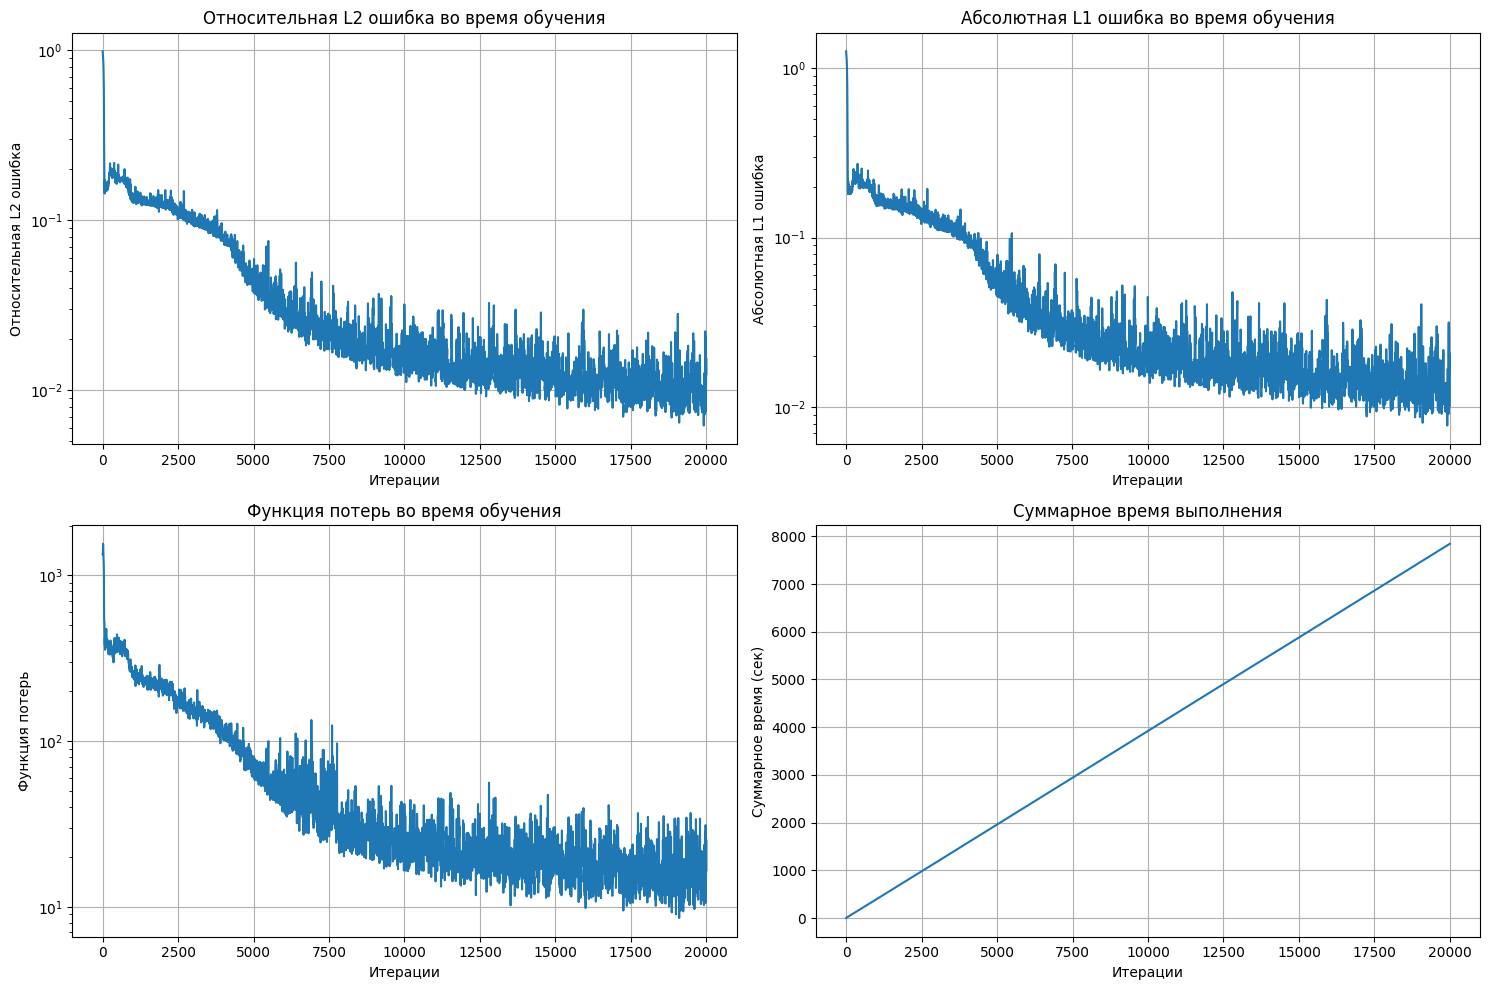

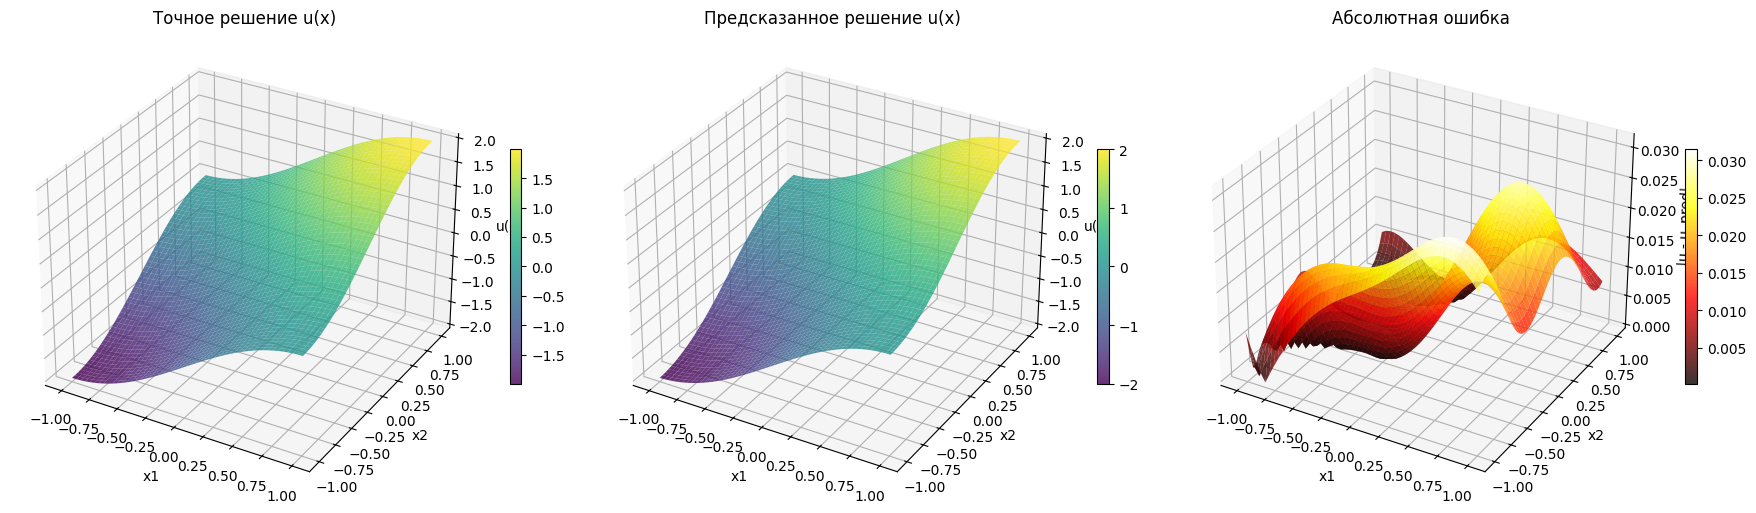

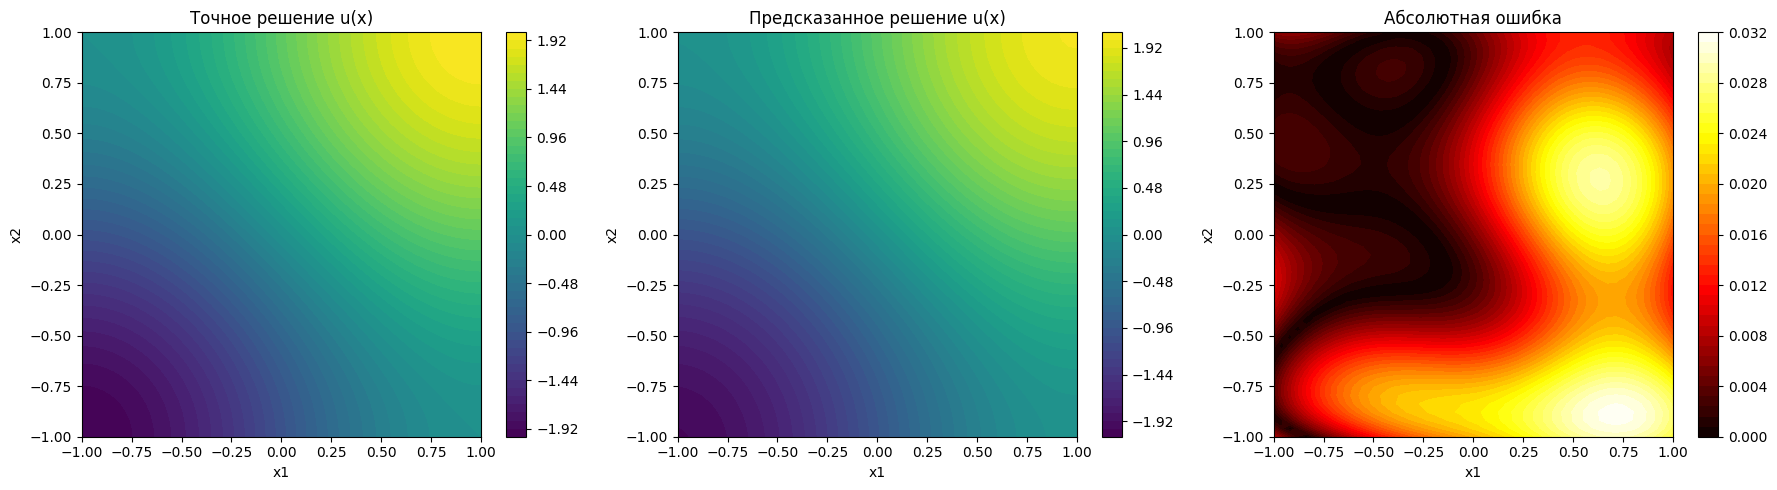

СТАТИСТИКА ОШИБОК
Финальная относительная L2 ошибка: 0.008419
Финальная абсолютная L2 ошибка: 0.013323
Финальная абсолютная L1 ошибка: 0.010701
Максимальная абсолютная ошибка: 0.042468


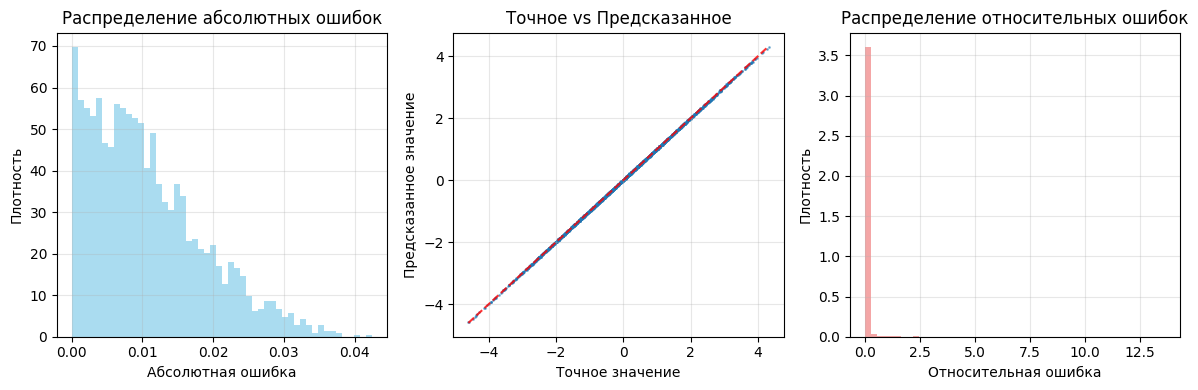


ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ
Общее время выборки: 52.57 сек
Общее время обучения: 7791.94 сек
Общее время интегрирования: 1289.45 сек
Общее время выполнения: 9133.97 сек
Среднее время на итерацию: 0.4567 сек


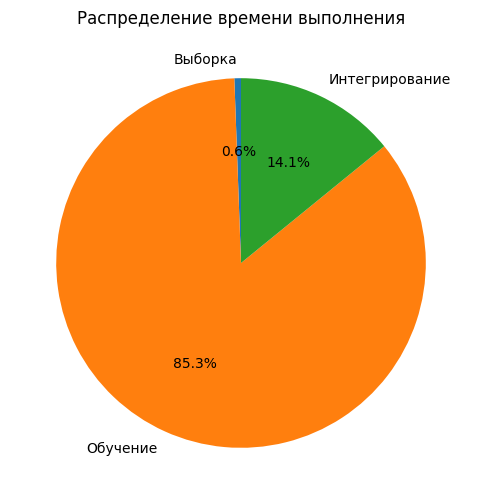


ИНФОРМАЦИЯ О ДАННЫХ
Размерность задачи: 20001 итераций
Количество тестовых точек: 2500
Размерность пространства: 5

Проверка наличия данных:
✓ test_dict - доступен
✓ pred_u - доступен
✓ pred_u_draw - доступен
✓ list_dict - доступен

Ключи в test_dict: ['mesh', 'test_x', 'draw_x', 'test_u', 'draw_u']
Ключи в list_dict: ['err_l2r_list', 'err_l1_list', 'train_loss_list', 'step_list', 'sample_time', 'train_time', 'integral_time']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def visualize_results(data_save):

    test_dict = data_save['test_dict']
    pred_u = data_save['pred_u']
    pred_u_draw = data_save['pred_u_draw']
    list_dict = data_save['list_dict']


    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))


    ax1.semilogy(list_dict['step_list'], list_dict['err_l2r_list'])
    ax1.set_xlabel('Итерации')
    ax1.set_ylabel('Относительная L2 ошибка')
    ax1.set_title('Относительная L2 ошибка во время обучения')
    ax1.grid(True)


    ax2.semilogy(list_dict['step_list'], list_dict['err_l1_list'])
    ax2.set_xlabel('Итерации')
    ax2.set_ylabel('Абсолютная L1 ошибка')
    ax2.set_title('Абсолютная L1 ошибка во время обучения')
    ax2.grid(True)


    ax3.semilogy(list_dict['step_list'], list_dict['train_loss_list'])
    ax3.set_xlabel('Итерации')
    ax3.set_ylabel('Функция потерь')
    ax3.set_title('Функция потерь во время обучения')
    ax3.grid(True)


    iterations = len(list_dict['sample_time'])
    cumulative_time = np.cumsum(list_dict['sample_time']) + np.cumsum(list_dict['train_time'])
    ax4.plot(range(iterations), cumulative_time)
    ax4.set_xlabel('Итерации')
    ax4.set_ylabel('Суммарное время (сек)')
    ax4.set_title('Суммарное время выполнения')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()


    if 'draw_x' in test_dict and 'draw_u' in test_dict:
        draw_x = test_dict['draw_x']
        draw_u = test_dict['draw_u']


        if draw_x.shape[1] >= 2:

            x1 = draw_x[:, 0]
            x2 = draw_x[:, 1]


            mesh_size = int(np.sqrt(len(x1)))
            X1 = x1.reshape(mesh_size, mesh_size)
            X2 = x2.reshape(mesh_size, mesh_size)


            U_exact = draw_u.reshape(mesh_size, mesh_size)


            U_pred = pred_u_draw.reshape(mesh_size, mesh_size)


            U_error = np.abs(U_exact - U_pred)


            fig = plt.figure(figsize=(18, 5))


            ax1 = fig.add_subplot(131, projection='3d')
            surf1 = ax1.plot_surface(X1, X2, U_exact, cmap='viridis', alpha=0.8)
            ax1.set_title('Точное решение u(x)')
            ax1.set_xlabel('x1')
            ax1.set_ylabel('x2')
            ax1.set_zlabel('u(x)')
            fig.colorbar(surf1, ax=ax1, shrink=0.5)


            ax2 = fig.add_subplot(132, projection='3d')
            surf2 = ax2.plot_surface(X1, X2, U_pred, cmap='viridis', alpha=0.8)
            ax2.set_title('Предсказанное решение u(x)')
            ax2.set_xlabel('x1')
            ax2.set_ylabel('x2')
            ax2.set_zlabel('u(x)')
            fig.colorbar(surf2, ax=ax2, shrink=0.5)


            ax3 = fig.add_subplot(133, projection='3d')
            surf3 = ax3.plot_surface(X1, X2, U_error, cmap='hot', alpha=0.8)
            ax3.set_title('Абсолютная ошибка')
            ax3.set_xlabel('x1')
            ax3.set_ylabel('x2')
            ax3.set_zlabel('|u - u_pred|')
            fig.colorbar(surf3, ax=ax3, shrink=0.5)

            plt.tight_layout()
            plt.show()


            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))


            cont1 = ax1.contourf(X1, X2, U_exact, levels=50, cmap='viridis')
            ax1.set_title('Точное решение u(x)')
            ax1.set_xlabel('x1')
            ax1.set_ylabel('x2')
            plt.colorbar(cont1, ax=ax1)


            cont2 = ax2.contourf(X1, X2, U_pred, levels=50, cmap='viridis')
            ax2.set_title('Предсказанное решение u(x)')
            ax2.set_xlabel('x1')
            ax2.set_ylabel('x2')
            plt.colorbar(cont2, ax=ax2)


            cont3 = ax3.contourf(X1, X2, U_error, levels=50, cmap='hot')
            ax3.set_title('Абсолютная ошибка')
            ax3.set_xlabel('x1')
            ax3.set_ylabel('x2')
            plt.colorbar(cont3, ax=ax3)

            plt.tight_layout()
            plt.show()


    print("=" * 50)
    print("СТАТИСТИКА ОШИБОК")
    print("=" * 50)


    if 'test_u' in test_dict:
        test_u = test_dict['test_u']
        final_l2_error = np.sqrt(np.mean((test_u - pred_u) ** 2))
        final_l1_error = np.mean(np.abs(test_u - pred_u))
        relative_l2_error = final_l2_error / np.sqrt(np.mean(test_u ** 2))

        print(f"Финальная относительная L2 ошибка: {relative_l2_error:.6f}")
        print(f"Финальная абсолютная L2 ошибка: {final_l2_error:.6f}")
        print(f"Финальная абсолютная L1 ошибка: {final_l1_error:.6f}")
        print(f"Максимальная абсолютная ошибка: {np.max(np.abs(test_u - pred_u)):.6f}")


    if 'test_u' in test_dict:
        errors = np.abs(test_dict['test_u'] - pred_u).flatten()

        plt.figure(figsize=(12, 4))

        plt.subplot(131)
        plt.hist(errors, bins=50, density=True, alpha=0.7, color='skyblue')
        plt.xlabel('Абсолютная ошибка')
        plt.ylabel('Плотность')
        plt.title('Распределение абсолютных ошибок')
        plt.grid(True, alpha=0.3)

        plt.subplot(132)
        plt.scatter(test_dict['test_u'].flatten(), pred_u.flatten(), alpha=0.5, s=1)
        plt.plot([test_dict['test_u'].min(), test_dict['test_u'].max()],
                [test_dict['test_u'].min(), test_dict['test_u'].max()], 'r--', alpha=0.8)
        plt.xlabel('Точное значение')
        plt.ylabel('Предсказанное значение')
        plt.title('Точное vs Предсказанное')
        plt.grid(True, alpha=0.3)

        plt.subplot(133)
        relative_errors = errors / (np.abs(test_dict['test_u'].flatten()) + 1e-8)
        plt.hist(relative_errors, bins=50, density=True, alpha=0.7, color='lightcoral')
        plt.xlabel('Относительная ошибка')
        plt.ylabel('Плотность')
        plt.title('Распределение относительных ошибок')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


    print("\n" + "=" * 50)
    print("ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ")
    print("=" * 50)

    total_sample_time = np.sum(list_dict['sample_time'])
    total_train_time = np.sum(list_dict['train_time'])
    total_integral_time = np.sum(list_dict['integral_time'])
    total_time = total_sample_time + total_train_time + total_integral_time

    print(f"Общее время выборки: {total_sample_time:.2f} сек")
    print(f"Общее время обучения: {total_train_time:.2f} сек")
    print(f"Общее время интегрирования: {total_integral_time:.2f} сек")
    print(f"Общее время выполнения: {total_time:.2f} сек")
    print(f"Среднее время на итерацию: {total_time/len(list_dict['sample_time']):.4f} сек")


    time_labels = ['Выборка', 'Обучение', 'Интегрирование']
    time_values = [total_sample_time, total_train_time, total_integral_time]

    plt.figure(figsize=(8, 6))
    plt.pie(time_values, labels=time_labels, autopct='%1.1f%%', startangle=90)
    plt.title('Распределение времени выполнения')
    plt.show()


print("Визуализация результатов...")
visualize_results(data_save)


print("\n" + "=" * 50)
print("ИНФОРМАЦИЯ О ДАННЫХ")
print("=" * 50)
print(f"Размерность задачи: {data_save['list_dict']['step_list'][-1] if 'step_list' in data_save['list_dict'] else 'N/A'} итераций")
print(f"Количество тестовых точек: {data_save['test_dict']['test_x'].shape[0]}")
print(f"Размерность пространства: {data_save['test_dict']['test_x'].shape[1]}")


print("\nПроверка наличия данных:")
for key in ['test_dict', 'pred_u', 'pred_u_draw', 'list_dict']:
    if key in data_save:
        print(f"✓ {key} - доступен")
    else:
        print(f"✗ {key} - отсутствует")

if 'test_dict' in data_save:
    print(f"\nКлючи в test_dict: {list(data_save['test_dict'].keys())}")
if 'list_dict' in data_save:
    print(f"Ключи в list_dict: {list(data_save['list_dict'].keys())}")